In [1]:
import os
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential, save_model, load_model
from keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.applications.vgg16 import decode_predictions
import cv2

In [2]:
train_dataset = os.path.join('train')
test_dataset = os.path.join('test')

def preprocess_input_vgg(img):
    return preprocess_input(img)

# Configuração do gerador de dados para pré-processamento e aumento de dados
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_vgg,
    rescale=1./255,         # Normaliza os valores dos pixels para o intervalo [0, 1]
    #shear_range=0.2,        # Aplica corte aleatório
    #zoom_range=0.2,         # Aplica zoom aleatório
    #horizontal_flip=True,   # Inverte aleatoriamente as imagens horizontalmente
)

# Carrega e pré-processa as imagens de treinamento
train_generator = datagen.flow_from_directory(
    train_dataset,
    target_size=(224, 224),  # Tamanho das imagens esperado pela InceptionV3
    batch_size=32,
    class_mode='categorical', # 'categorical' se for classificação com mais de duas classes
    #subset='training'        # Especifica se é para conjunto de treinamento
    
)

# Carrega e pré-processa as imagens de validação
test_generator = datagen.flow_from_directory(
    test_dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    #subset='validation'      # Especifica se é para conjunto de validação
)

Found 18325 images belonging to 10 classes.
Found 7854 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


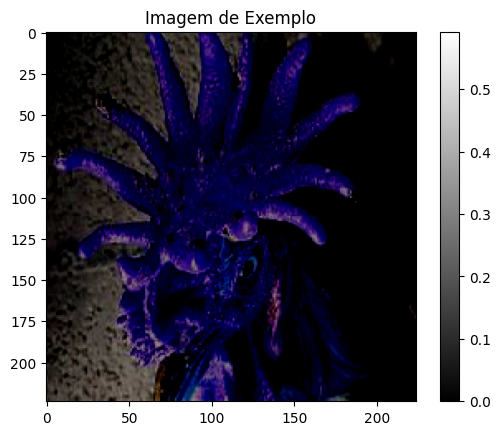

In [3]:
random1 = np.random.randint(0, 572)
random2 = np.random.randint(0, 31)
plt.imshow(train_generator[random1][0][random2], cmap='gray')  # cmap é o mapa de cores, 'gray' para uma imagem em tons de cinza
plt.title('Imagem de Exemplo')
plt.colorbar()  # Adiciona uma barra de cores para referência
plt.show()

In [ ]:
# Passo 1: Carregar modelo VGG16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Passo 2: Congelar camadas convolucionais
for layer in base_model.layers:
    layer.trainable = False

# Passo 3: Adicionar camadas personalizadas no topo
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  # Substitua 10 pelo número de suas classes

# Exibir a arquitetura do modelo
model.summary()

# Passo 4: Configurar e compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001),  # Ajuste conforme necessário
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinamento do modelo
model.fit(train_generator, epochs=1)  # Ajuste conforme necessário

In [17]:
model = Sequential()

# Bloco 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Bloco 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Bloco 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Bloco 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Bloco 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Camada Flatten
model.add(Flatten())

# Camadas Densas
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=2, batch_size=64, validation_data=test_generator)

Epoch 1/2
573/573 [==============================] - ETA: 0s - loss: 1.9886 - accuracy: 0.2927 

In [6]:
target_names = ['Aranha', 'Borboleta', 'Cachorro', 'Cavalo', 'Elefante', 'Esquilo', 'Galinha', 'Gato', 'Ovelha', 'Vaca']
test_generator.reset()
predictions = model.predict(test_generator)

y_pred_array = np.argmax(predictions, axis=1)

# y_pred = np.argmax(y_pred_array, axis=1)
# test_generator
y_true = test_generator.classes
# report = classification_report(y_true, y_pred_array, target_names=target_names)
# print(report)

246/246 [==============================] - 494s 2s/step


In [8]:

print("Accuracy:", metrics.accuracy_score(y_pred_array, y_true))
print("F1-score:", metrics.f1_score(y_pred_array, y_true, average='micro'))
print("Precision:", metrics.precision_score(y_pred_array, y_true, average='micro'))
print("Recall:", metrics.recall_score(y_pred_array, y_true, average='micro'))

# plt.ylim(0, 0.5)
# plt.yticks(np.arange(0, 0.5, 0.1))

# Plotagem da loss
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Mudança da Loss durante o Treinamento')
plt.legend()
plt.show()
# Plotagem da accuracy
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Mudança da Acurácia durante o Treinamento')
plt.legend()
plt.show()

Accuracy: 0.11917494270435447
F1-score: 0.11917494270435447
Precision: 0.11917494270435447
Recall: 0.11917494270435447


NameError: name 'loss_values' is not defined